## 特徴量を選択しstratifiedKHoldを設定してGridSearchでトレーニングする

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 253, number of negative: 1421
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 1674, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151135 -> initscore=-1.725727
[LightGBM] [Info] Start training from score -1.725727
[LightGBM] [Info] Number of positive: 252, number of negative: 1421
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 1673, number of used features: 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150628 -> initscore=-1.729687
[LightGBM] [Info] Start training from score -1.729687
[LightGBM] [Info] Number of positive: 253, number of negative: 1420
[LightGBM] [Info] Number of positive: 253, number of negative: 1421
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points 

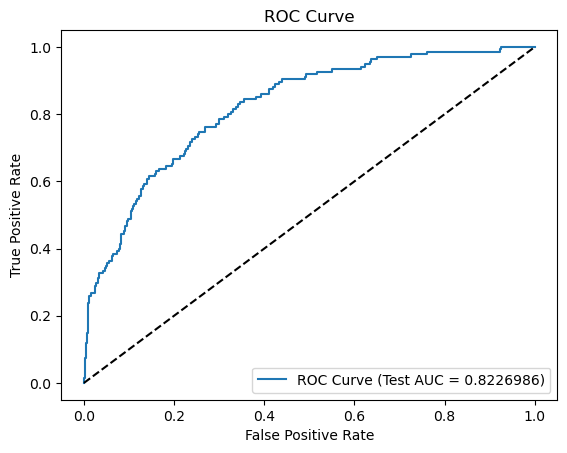

最適なLightGBMモデルが /Users/hayakawakazue/Downloads/signate/model/lgbm_select_futures_0830_grid.joblib に保存されました。


In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
import os

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Product_Designation_Target_Encoding', 'FamilySize',
    'MaritalStatus', 'Income_Bucket_Rank', 'Passport', 
    'Age_MonthlyIncome_Interaction', 'Occupation_Large_Business', 'Gender_Female',
    'EngagementScore', 'Cluster_ProdTaken_Ratio', 'NumberOfTrips',
    'TypeofContact_Company_Invited', 'Occupation_Salaried', 'Age_ProdTaken_Mean',
    'ProductPitched_Satisfaction', 'Satisfaction_PerVisitor', 'ProductPitched_Rank',
    'CityTier_Age_Income_x_FamilySize_Income', 'PreferredPropertyStar'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18, stratify=y)

# LightGBMモデルのインスタンスを作成し、force_col_wise=True を設定
lgbm_model = LGBMClassifier(random_state=18, force_col_wise=True)

# ハイパーパラメータの候補を設定
param_grid = {
    'num_leaves': [30, 50],
    'max_depth': [2,3, 5],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# StratifiedKFoldを設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

# グリッドサーチの設定
lgbm_grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=skf, 
                                scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
lgbm_grid_search.fit(X_train, y_train)

# 最適なモデルを取得
lgbm_best = lgbm_grid_search.best_estimator_

# 最適なモデルで再トレーニング（全データを使用）
lgbm_best.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {lgbm_grid_search.best_params_}")
print(f"Best cross-validation AUC: {lgbm_grid_search.best_score_:.4f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(lgbm_best, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.4f}")

# テストデータでの予測とAUC計算
y_pred_proba = lgbm_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc:.4f}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'lgbm_select_futures_0830_grid.joblib')
joblib.dump(lgbm_best, model_path)
print(f"最適なLightGBMモデルが {model_path} に保存されました。")


## REFを設定してランダムサーチでトレーニングする

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import RFE

import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled_features.csv'
data = pd.read_csv(data_path)

# 特徴量とターゲットに分割
X = data.drop(columns=['ProdTaken'])
y = data['ProdTaken']

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# LightGBMモデルのインスタンス作成
lgb_model = lgb.LGBMClassifier(random_state=12)

# RFEを使って特徴量選択
rfe = RFE(estimator=lgb_model, n_features_to_select=20, step=1)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)

# パラメータの選択範囲を設定
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.logspace(-4, -1, 50),
    'n_estimators': np.arange(50, 300, 50),
    'subsample': np.linspace(0.6, 1.0, 10),
    'colsample_bytree': np.linspace(0.6, 1.0, 10)
}

# ランダムサーチの設定
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,  # 試行回数を指定
    scoring='roc_auc',
    cv=10,  # クロスバリデーションの分割数
    random_state=12,
    n_jobs=-1,  # 並列処理を使用
    verbose=2
)

# ランダムサーチによるハイパーパラメータチューニングとトレーニング
random_search.fit(X_train_selected, y_train)

# ベストパラメータとベストスコアの表示
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation AUC: {random_search.best_score_}")

# 最適なモデルを取得
lgb_best = random_search.best_estimator_

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(lgb_best, X_train_selected, y_train, cv=10, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = lgb_best.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# モデルの保存
model_path = '/Users/hayakawakazue/Downloads/signate/model/lgbm_rfe_randomsearch0814_1.joblib'
joblib.dump(lgb_best, model_path)
print(f"最適なモデルが {model_path} に保存されました。")

# 選択された特徴量の表示
selected_features = X.columns[rfe.get_support()]
print("Selected Features:", selected_features)


[LightGBM] [Info] Number of positive: 265, number of negative: 1443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 1708, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.155152 -> initscore=-1.694750
[LightGBM] [Info] Start training from score -1.694750
[LightGBM] [Info] Number of positive: 265, number of negative: 1443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 1708, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.155152 -> initscore=-1.694750
[LightGBM] [

## 特徴量を選択しランダムサーチでトレーニングする

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 284, number of negative: 1669
[LightGBM] [Info] Number of positive: 284, number of negative: 1669
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 1953, number of used features: 12
[LightGBM] [Info] Number of data points in the train set: 1953, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145417 -> initscore=-1.771006
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145417 -> initscore=-1.771006
[LightGBM] [Info] Start training from score -1.771006
[LightGBM] [Info] Start training from score -1.771006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

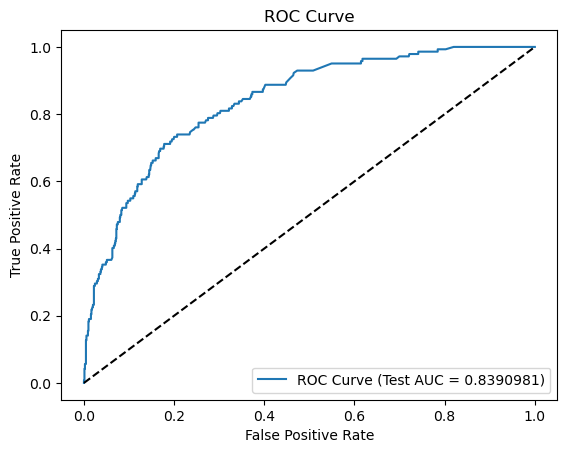

最適なLightGBMモデルが /Users/hayakawakazue/Downloads/signate/model/lightgbm_random0810_1.joblib に保存されました。


In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'MonthlyIncome', 'Designation_Executive', 'Age', 'Occupation_ProdTaken_Mean',
    'DurationOfPitch', 'NumberOfTrips', 'ProductPitched_ProdTaken_Std', 'StatusScore', 
    'ProductPitched_ProdTaken_Var', 'Passport', 'CityTier', 'FamilySize'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの範囲を設定
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# LightGBMモデルの定義
lgb_model = lgb.LGBMClassifier(random_state=42, force_col_wise=True)

# ランダムサーチの設定
lgb_random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1)

# ランダムサーチの実行
lgb_random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {lgb_random_search.best_params_}")
print(f"Best cross-validation AUC: {lgb_random_search.best_score_:.4f}")

# 最適なモデルを取得
lgb_best = lgb_random_search.best_estimator_

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(lgb_best, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = lgb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'lightgbm_random0810_1.joblib')
joblib.dump(lgb_best, model_path)
print(f"最適なLightGBMモデルが {model_path} に保存されました。")


## 特徴量を選択しグリットサーチでトレーニングする

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'MonthlyIncome', 'Designation_Executive', 'Age', 'Occupation_ProdTaken_Mean',
    'DurationOfPitch', 'NumberOfTrips', 'ProductPitched_ProdTaken_Std', 'StatusScore', 
    'ProductPitched_ProdTaken_Var', 'Passport', 'CityTier', 'FamilySize'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの候補を設定
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 50],
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'max_depth': [-1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# LightGBMモデルの定義
lgb_model = lgb.LGBMClassifier(random_state=42, force_col_wise=True)

# グリッドサーチの設定
lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
lgb_grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {lgb_grid_search.best_params_}")
print(f"Best cross-validation AUC: {lgb_grid_search.best_score_:.7f}")

# 最適なモデルを取得
lgb_best = lgb_grid_search.best_estimator_

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(lgb_best, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = lgb_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'lightgbm0810_1.joblib')
joblib.dump(lgb_best, model_path)
print(f"最適なLightGBMモデルが {model_path} に保存されました。")


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[LightGBM] [Info] Number of positive: 284, number of negative: 1669
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 1953, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145417 -> initscore=-1.771006
[LightGBM] [Info] Start training from score -1.771006
[LightGBM] [Info] Number of positive: 284, number of negative: 1670
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 1954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145343 -> initscore=-1.771605
[LightGBM] [Info] Start training from score -1.771605
[LightGBM] [Info] Number of positive: 284, number of negative: 1670
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 1954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145343 -> initscore=-1.771605
[LightGBM

KeyboardInterrupt: 